# 1.7f: Shell Structure Analysis

We discovered that 2,179 tokens (96.9% of the cluster) sit at radius r = 0.00007553.

**Question:** Are they:
1. **Spherically distributed** - scattered across a 2559D hypersphere?
2. **Collapsed to a point** - all at the same lat/lon with tiny noise?

**Test:** Plot latitude vs longitude and measure angular separations.

## Parameters

In [6]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# The magic radius value
MAGIC_RADIUS = 0.00007553

# Tolerance for identifying magic radius tokens
RADIUS_TOLERANCE = 1e-7

# Visualization
DPI = 200

## Imports

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Data

In [8]:
# Load spherical coords
spherical_path = Path(f"../tensors/{MODEL_NAME}/1.7c_cluster_spherical.safetensors")
spherical_data = load_file(spherical_path)

r = spherical_data["r"]
lat_deg = spherical_data["lat_deg"]
lon_deg = spherical_data["lon_deg"]
cluster_token_ids = spherical_data["cluster_token_ids"]

n_cluster = len(r)

print(f"Loaded spherical coords from {spherical_path}")
print(f"  Total tokens: {n_cluster:,}")

Loaded spherical coords from ../tensors/Qwen3-4B-Instruct-2507/1.7c_cluster_spherical.safetensors
  Total tokens: 2,248


## Filter to Magic Radius Tokens

In [9]:
print(f"\nFiltering to magic radius tokens...\n")

# Find tokens at magic radius (with more generous tolerance for float32)
magic_mask = torch.abs(r - MAGIC_RADIUS) < RADIUS_TOLERANCE
n_magic = magic_mask.sum().item()

# Extract their coordinates
magic_lat = lat_deg[magic_mask]
magic_lon = lon_deg[magic_mask]
magic_r = r[magic_mask]
magic_token_ids = cluster_token_ids[magic_mask]

print(f"Magic radius tokens: {n_magic:,} ({n_magic/n_cluster*100:.1f}% of cluster)")
print(f"\nRadius statistics:")
print(f"  Min: {magic_r.min().item():.10f}")
print(f"  Max: {magic_r.max().item():.10f}")
print(f"  Mean: {magic_r.mean().item():.10f}")
print(f"  Std: {magic_r.std().item():.2e}")


Filtering to magic radius tokens...

Magic radius tokens: 2,179 (96.9% of cluster)

Radius statistics:
  Min: 0.0000755272
  Max: 0.0000755272
  Mean: 0.0000755272
  Std: 0.00e+00


## Latitude/Longitude Statistics

In [10]:
print("\nLatitude/Longitude ranges:\n")

lat_min = magic_lat.min().item()
lat_max = magic_lat.max().item()
lat_span = lat_max - lat_min

lon_min = magic_lon.min().item()
lon_max = magic_lon.max().item()
lon_span = lon_max - lon_min

print(f"Latitude:")
print(f"  Range: [{lat_min:.2f}°, {lat_max:.2f}°]")
print(f"  Span: {lat_span:.2f}°")
print(f"  Mean: {magic_lat.mean().item():.2f}°")
print(f"  Std: {magic_lat.std().item():.2f}°")
print()
print(f"Longitude:")
print(f"  Range: [{lon_min:.2f}°, {lon_max:.2f}°]")
print(f"  Span: {lon_span:.2f}°")
print(f"  Mean: {magic_lon.mean().item():.2f}°")
print(f"  Std: {magic_lon.std().item():.2f}°")
print()
print(f"Interpretation:")
if lat_span < 1 and lon_span < 1:
    print(f"  POINT-LIKE: Span < 1° in both directions")
    print(f"  All tokens clustered at ({magic_lat.mean().item():.2f}°, {magic_lon.mean().item():.2f}°)")
elif lat_span < 10 and lon_span < 10:
    print(f"  SMALL PATCH: Span < 10° - tokens in a localized region")
elif lat_span > 90 or lon_span > 180:
    print(f"  WIDELY DISTRIBUTED: Tokens scattered across large portion of sphere")
else:
    print(f"  MODERATE SPREAD: Tokens occupy a {lat_span:.0f}° × {lon_span:.0f}° patch")


Latitude/Longitude ranges:

Latitude:
  Range: [-53.91°, -53.91°]
  Span: 0.00°
  Mean: -53.91°
  Std: 0.00°

Longitude:
  Range: [59.04°, 59.04°]
  Span: 0.00°
  Mean: 59.04°
  Std: 0.00°

Interpretation:
  POINT-LIKE: Span < 1° in both directions
  All tokens clustered at (-53.91°, 59.04°)


## Scatter Plot: Latitude vs Longitude


Plotting lat/lon scatter...



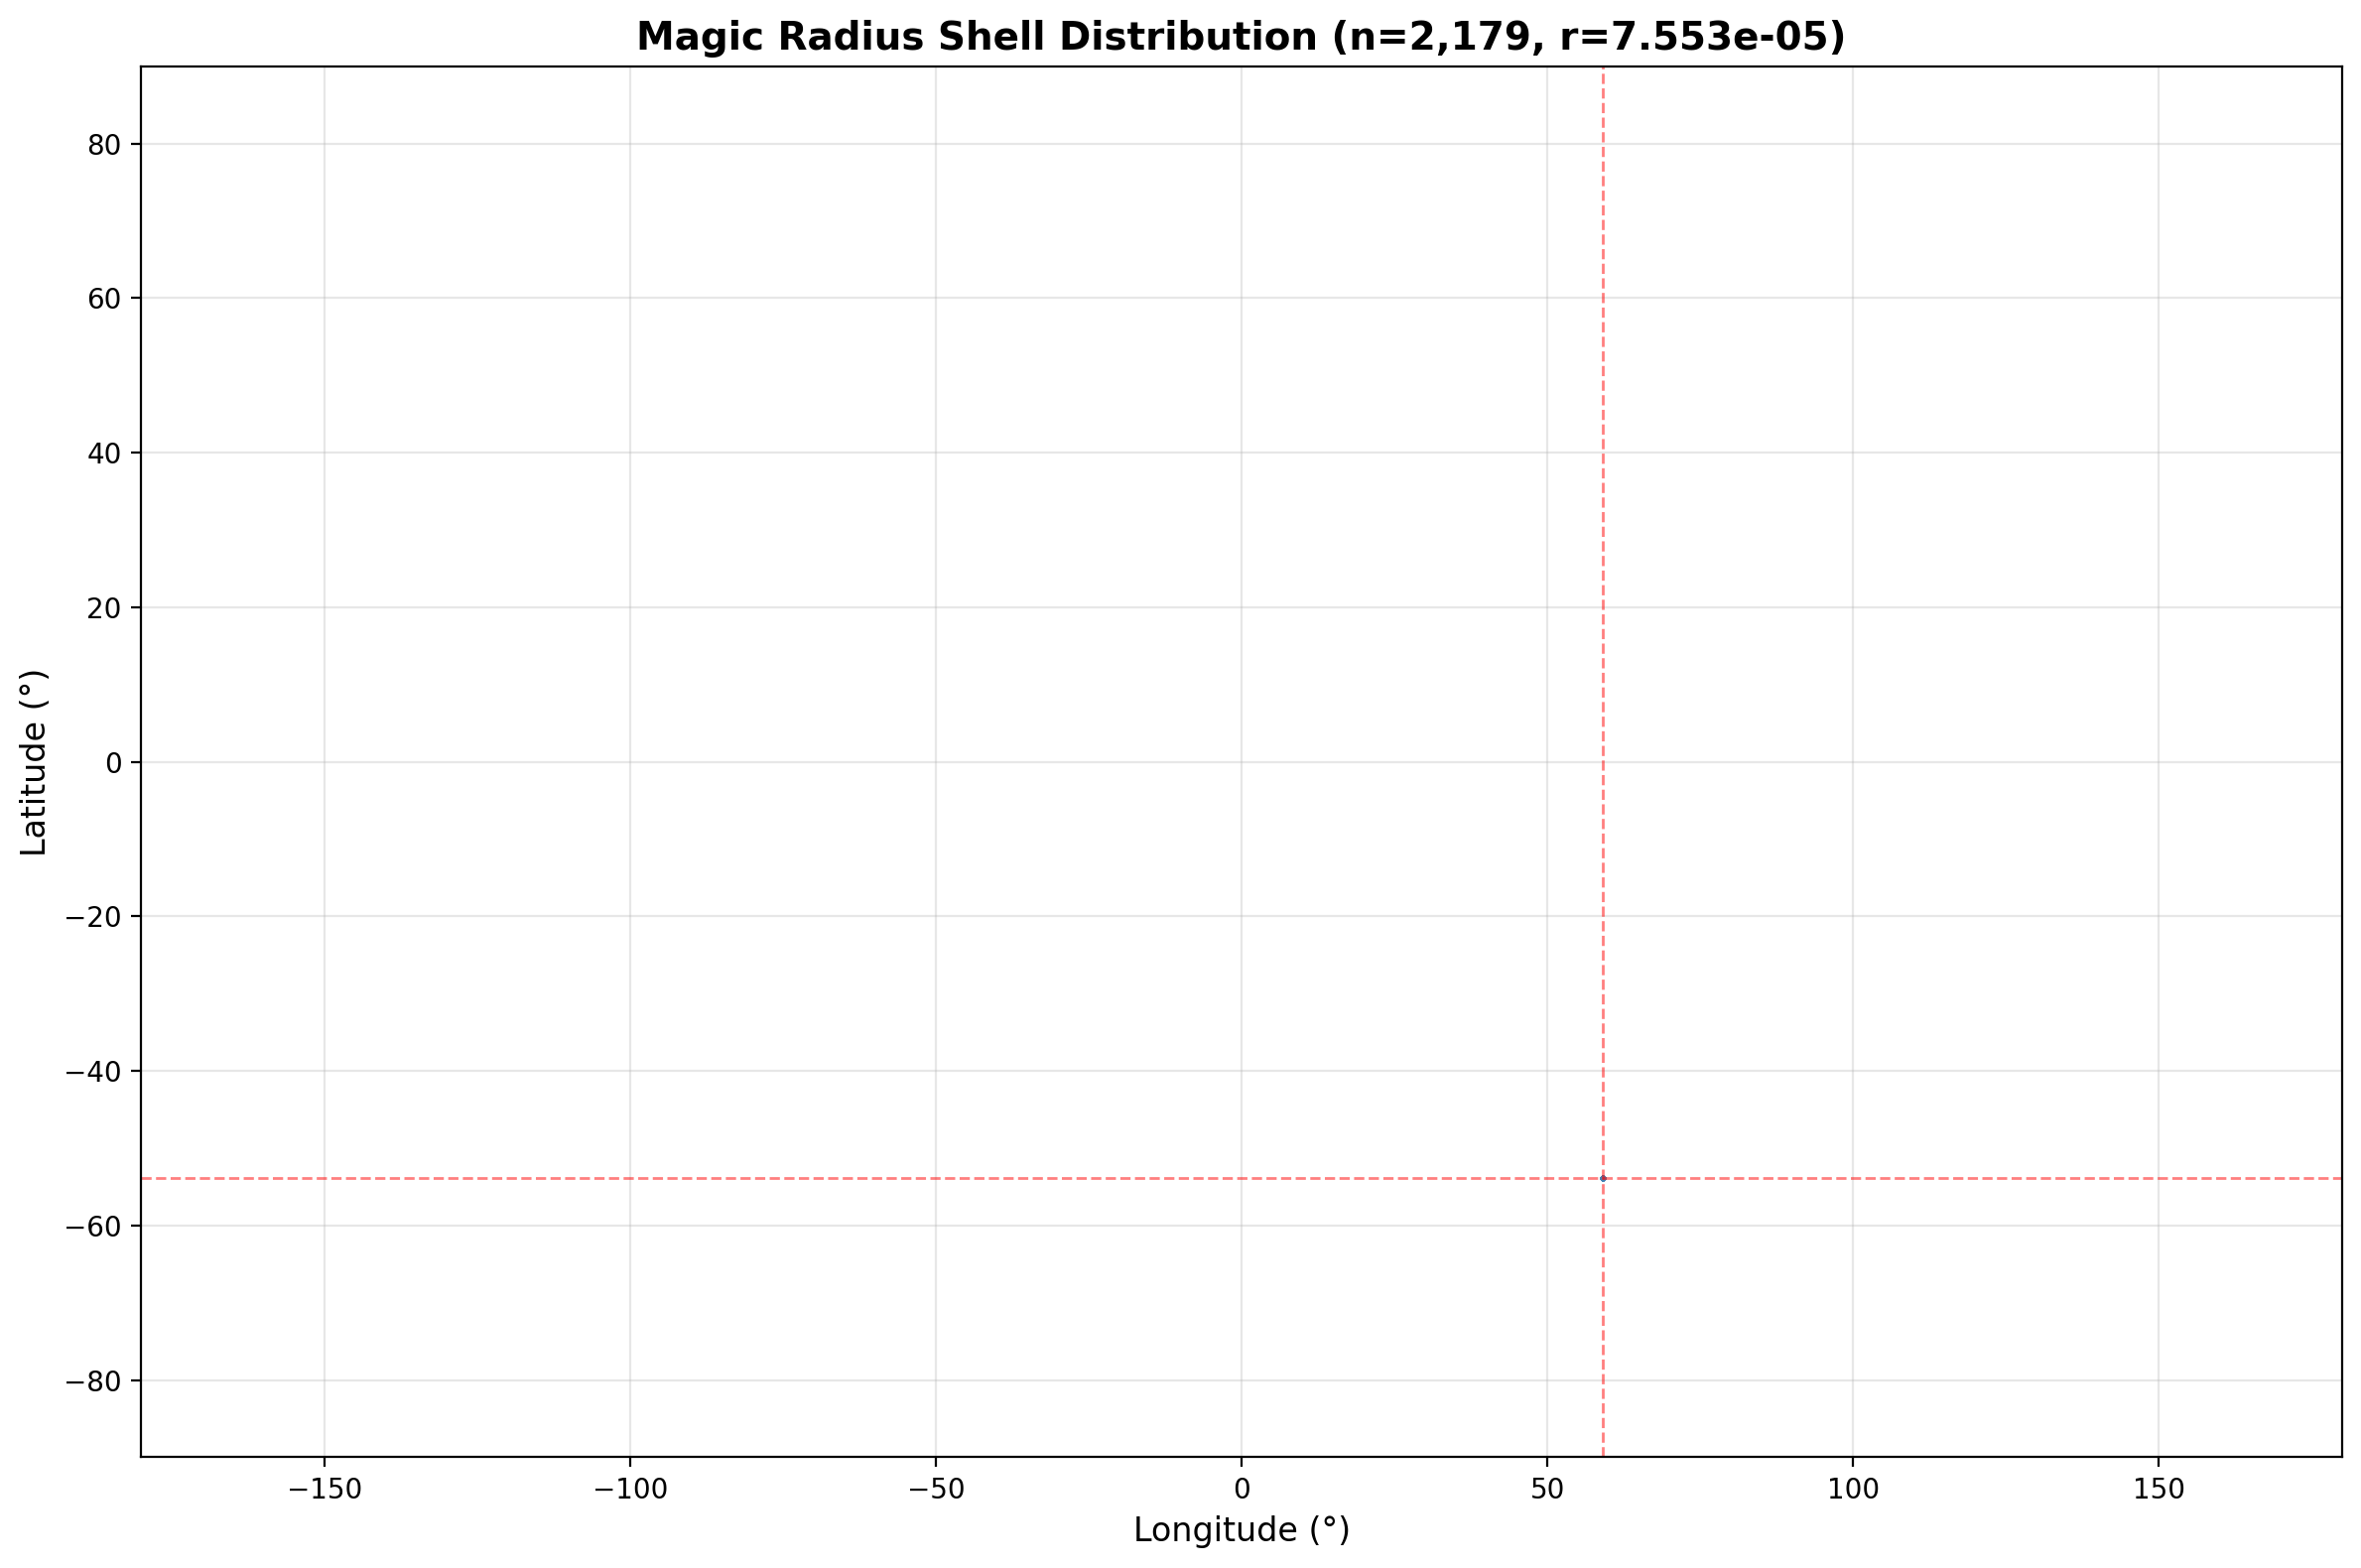

✓ Plotted scatter


In [11]:
print("\nPlotting lat/lon scatter...\n")

fig, ax = plt.subplots(figsize=(12, 8), dpi=DPI)

# Scatter plot
scatter = ax.scatter(magic_lon.numpy(), magic_lat.numpy(), 
                     s=1, alpha=0.5, c='steelblue')

ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)
ax.set_title(f'Magic Radius Shell Distribution (n={n_magic:,}, r={MAGIC_RADIUS})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Add crosshair at mean
ax.axhline(magic_lat.mean().item(), color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(magic_lon.mean().item(), color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("✓ Plotted scatter")

## Histograms: Latitude and Longitude Distributions


Plotting lat/lon histograms...



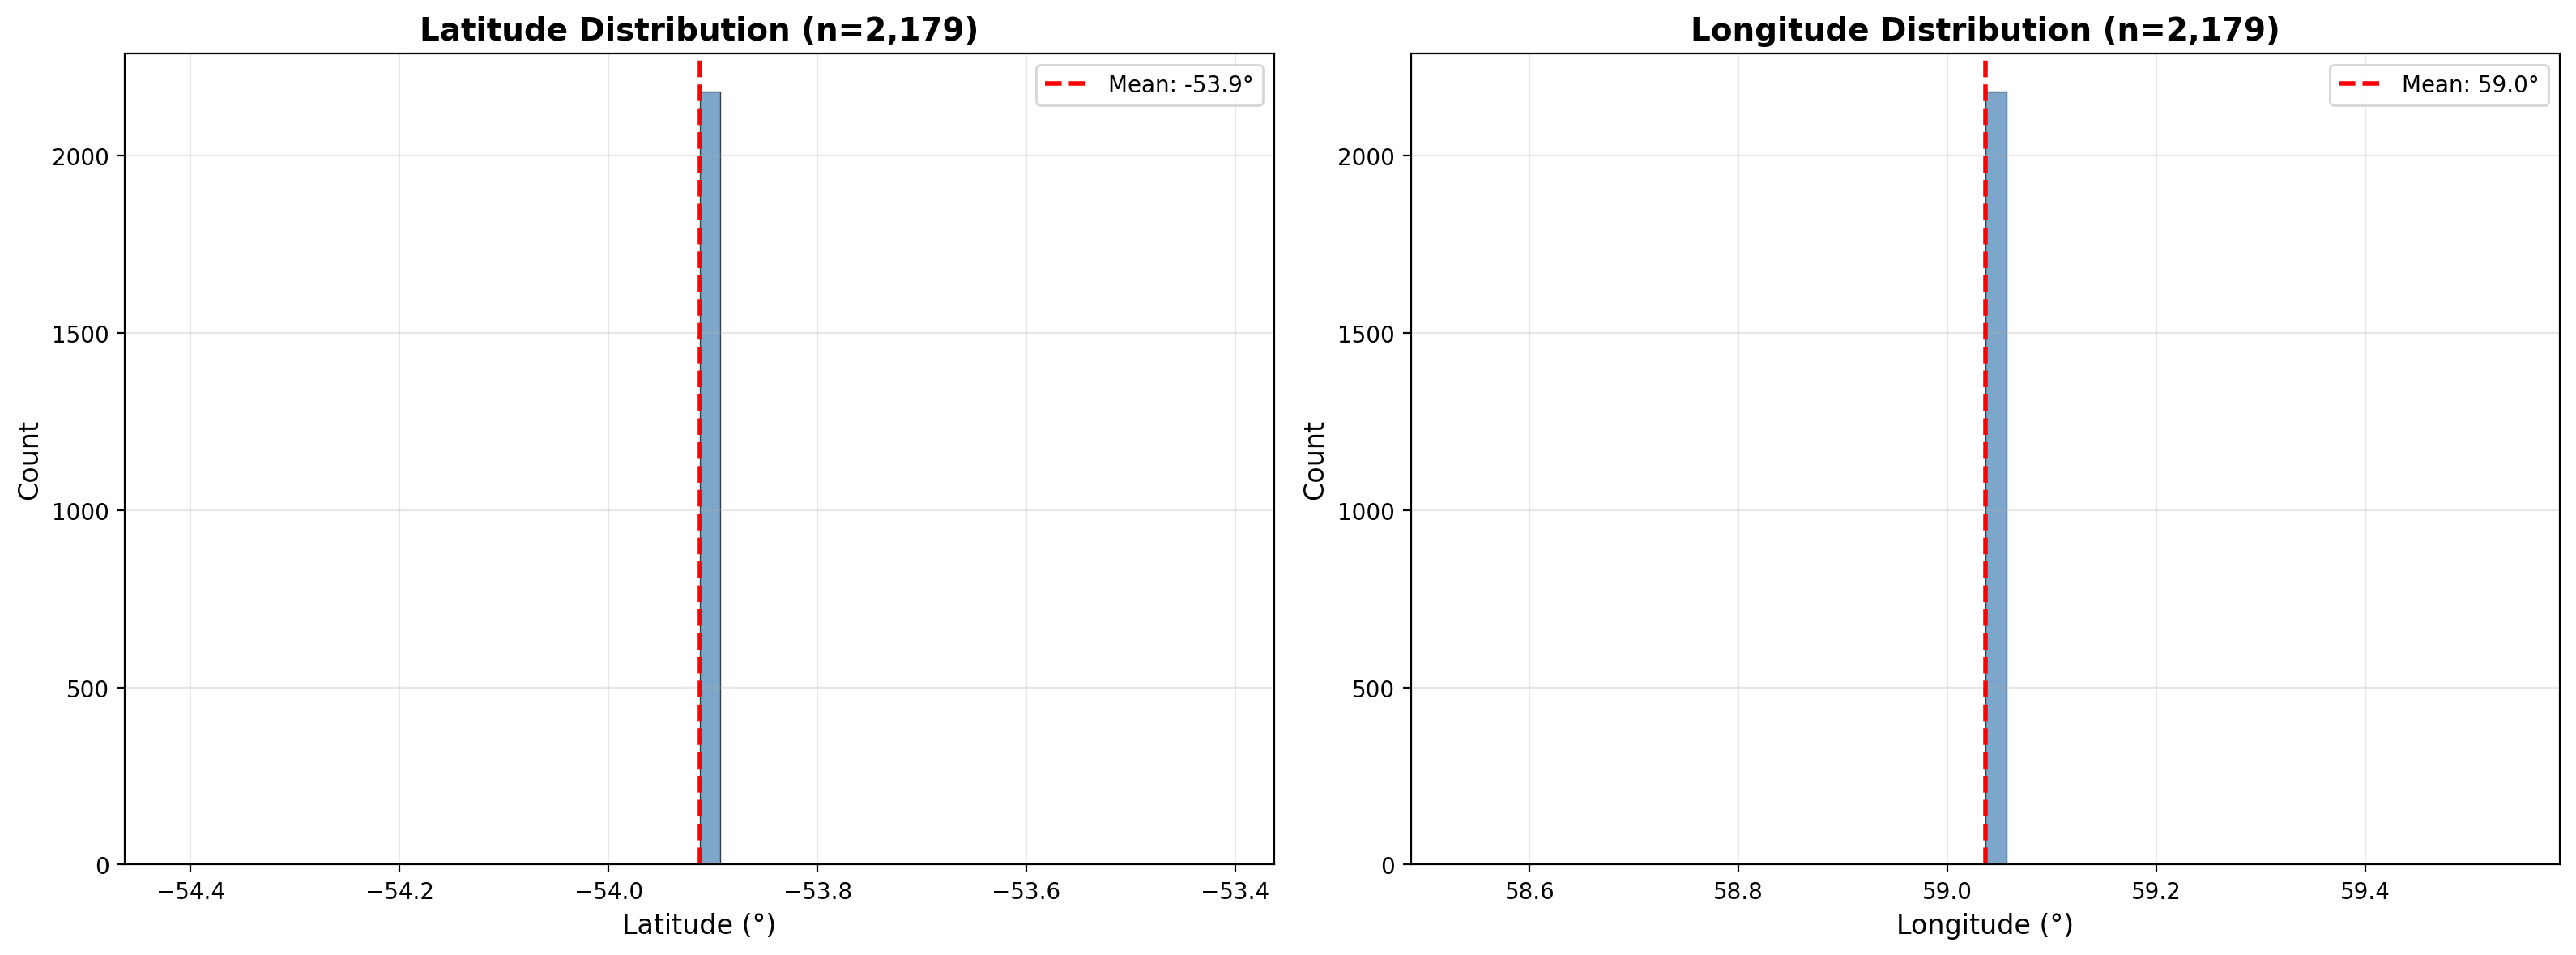

✓ Plotted histograms


In [12]:
print("\nPlotting lat/lon histograms...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Latitude histogram
ax1.hist(magic_lat.numpy(), bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Latitude (°)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Latitude Distribution (n={n_magic:,})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(magic_lat.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {magic_lat.mean().item():.1f}°')
ax1.legend()

# Longitude histogram
ax2.hist(magic_lon.numpy(), bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Longitude (°)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'Longitude Distribution (n={n_magic:,})', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(magic_lon.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {magic_lon.mean().item():.1f}°')
ax2.legend()

plt.tight_layout()
plt.show()

print("✓ Plotted histograms")

## 2D Histogram (Heatmap)


Plotting 2D density heatmap...



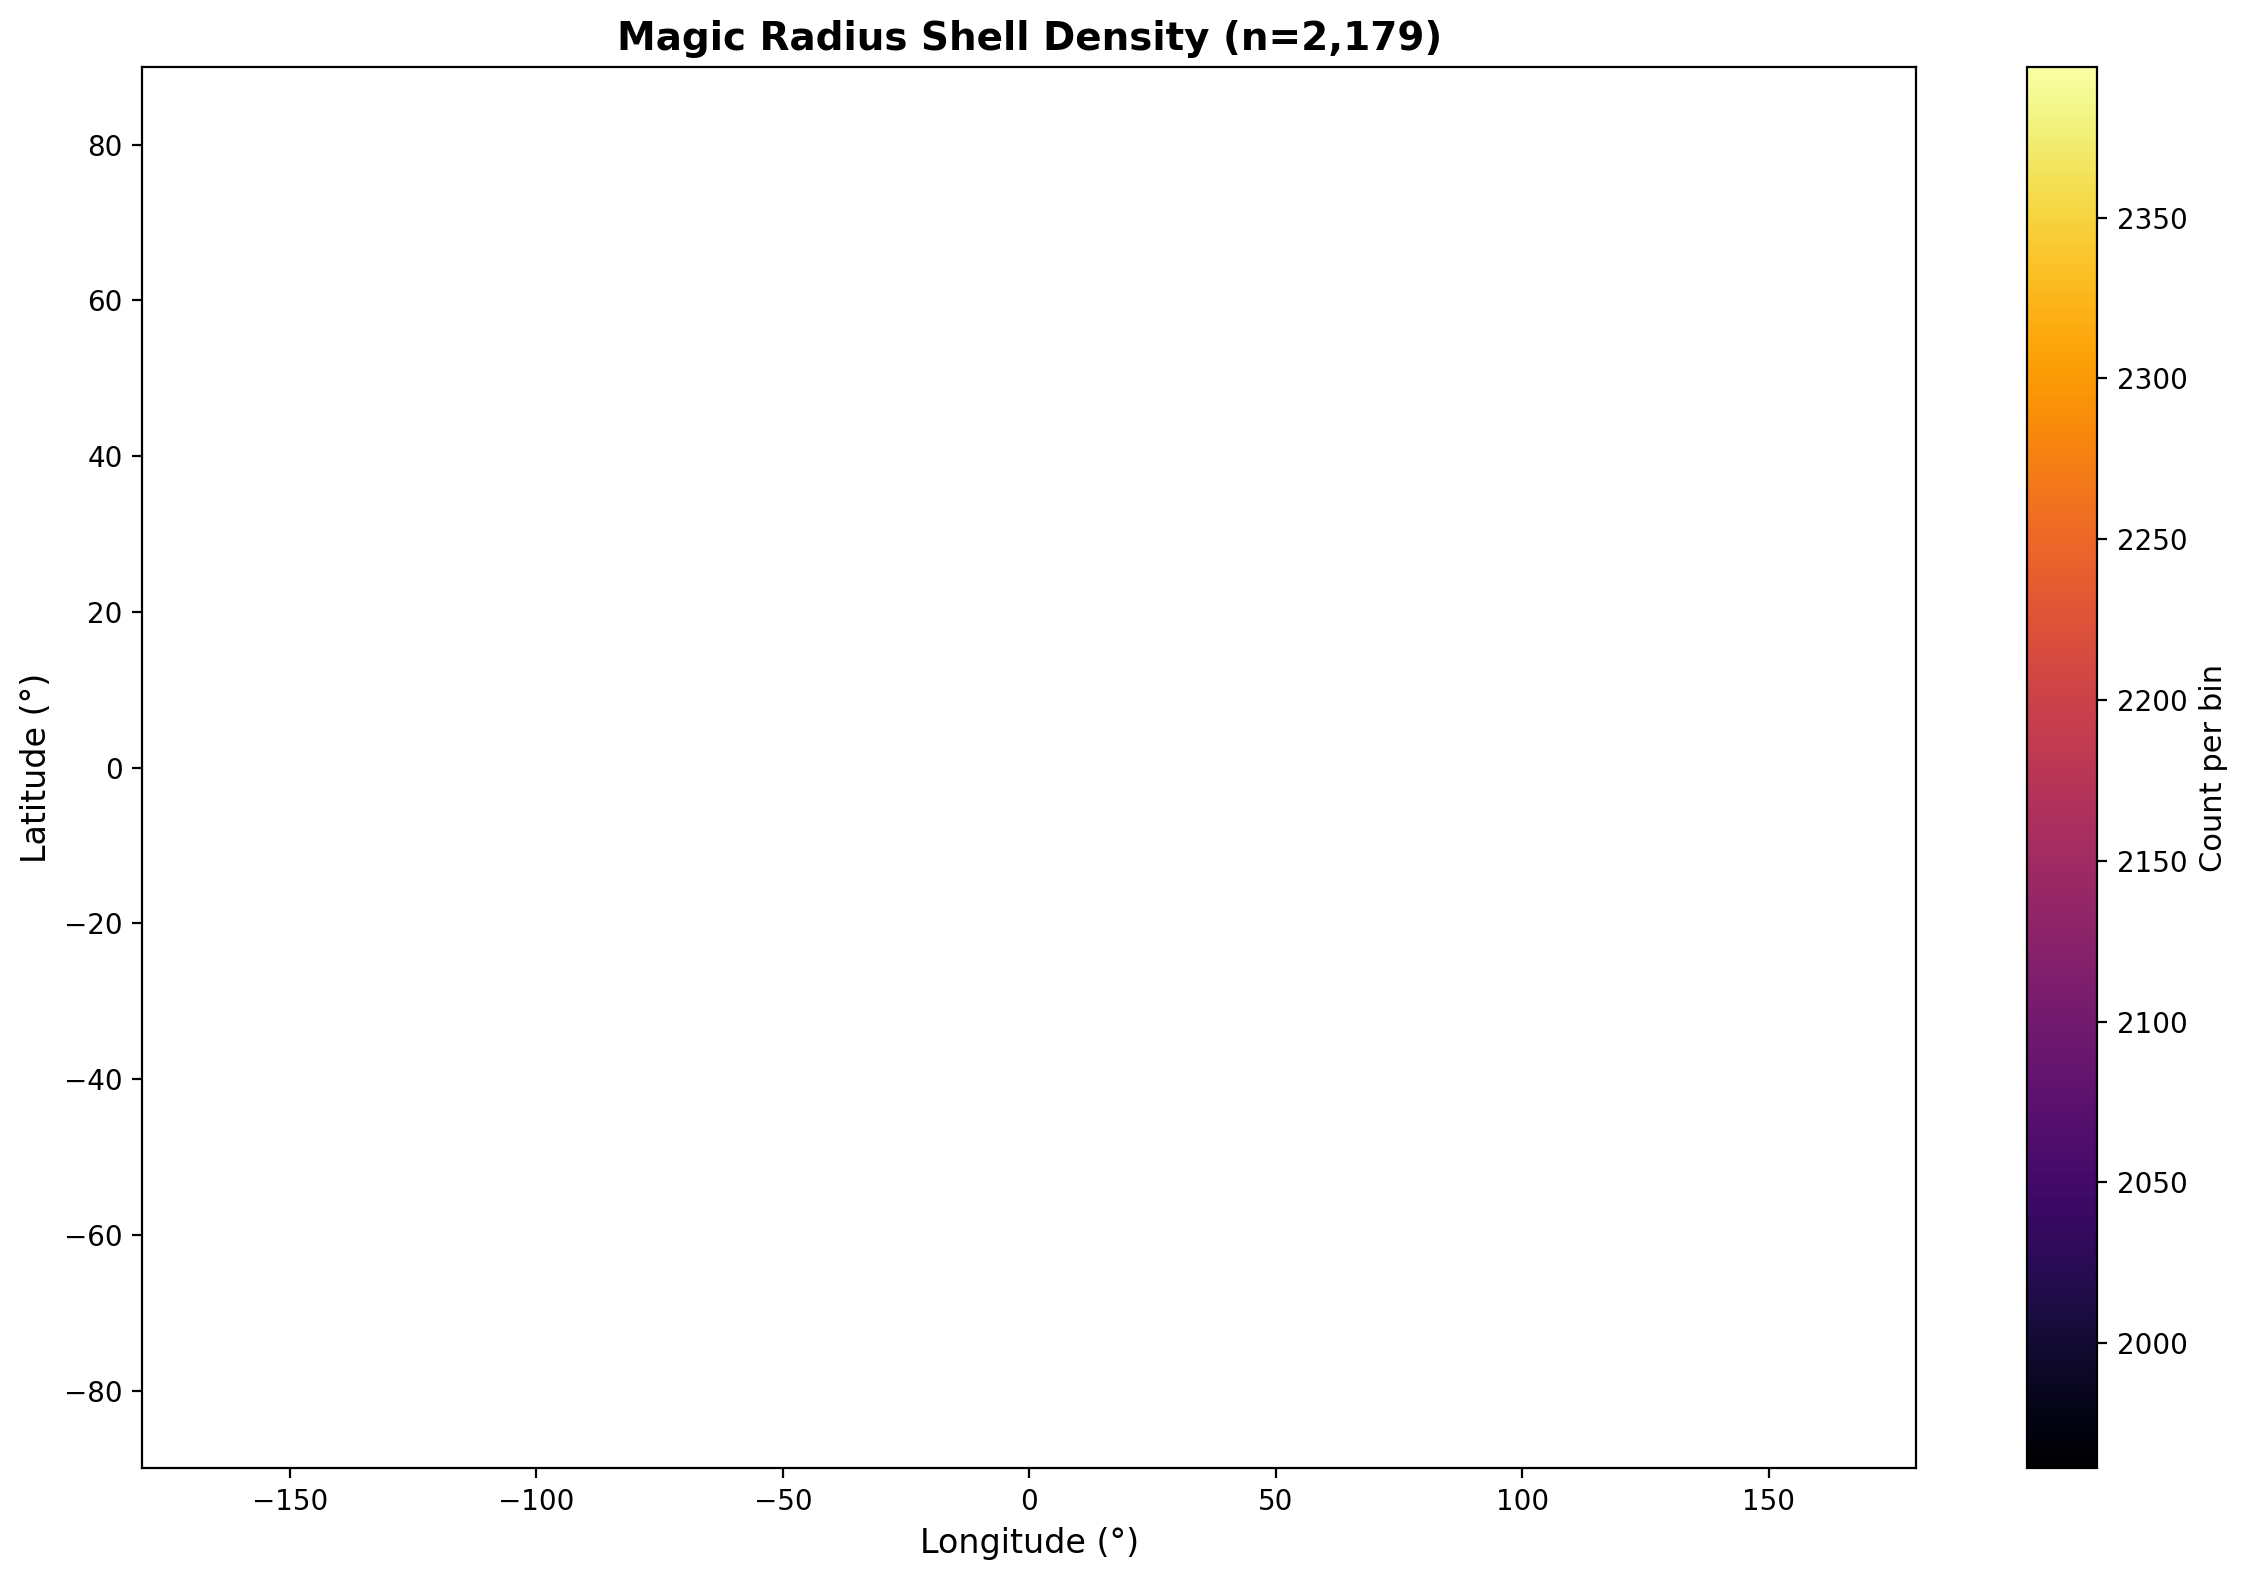

✓ Plotted heatmap


In [13]:
print("\nPlotting 2D density heatmap...\n")

fig, ax = plt.subplots(figsize=(12, 8), dpi=DPI)

# 2D histogram
h = ax.hist2d(magic_lon.numpy(), magic_lat.numpy(), 
              bins=50, cmap='inferno', cmin=1)

ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)
ax.set_title(f'Magic Radius Shell Density (n={n_magic:,})', fontsize=14, fontweight='bold')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label('Count per bin', fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Plotted heatmap")

## Angular Separation Statistics

In [17]:
print("\nComputing angular separations (sampling for speed)...\n")

# Sample 100 tokens to compute pairwise separations
# (Computing all pairs would be 2179² = 4.7M distances)
n_sample = min(100, n_magic)
sample_indices = torch.randperm(n_magic)[:n_sample]

sample_lat = magic_lat[sample_indices]
sample_lon = magic_lon[sample_indices]

# Convert to radians
lat_rad = torch.deg2rad(sample_lat)
lon_rad = torch.deg2rad(sample_lon)

# Compute pairwise great circle distances (haversine formula)
# For points on a sphere: angular_dist = arccos(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon1-lon2))

angular_dists = []
for i in range(n_sample):
    for j in range(i+1, n_sample):
        lat1, lon1 = lat_rad[i], lon_rad[i]
        lat2, lon2 = lat_rad[j], lon_rad[j]
        
        # Great circle distance
        cos_dist = torch.sin(lat1)*torch.sin(lat2) + torch.cos(lat1)*torch.cos(lat2)*torch.cos(lon1-lon2)
        cos_dist = torch.clamp(cos_dist, -1, 1)  # Numerical stability
        angular_dist = torch.acos(cos_dist)
        angular_dists.append(torch.rad2deg(angular_dist).item())

angular_dists = np.array(angular_dists)

print(f"Angular separation statistics (sampled {n_sample} tokens):")
print(f"  Min: {angular_dists.min():.4f}°")
print(f"  Max: {angular_dists.max():.4f}°")
print(f"  Mean: {angular_dists.mean():.4f}°")
print(f"  Median: {np.median(angular_dists):.4f}°")
print(f"  Std: {angular_dists.std():.4f}°")
print()
print(f"Interpretation:")
if angular_dists.max() < 1:
    print(f"  POINT-LIKE: Max separation < 1° - all tokens essentially at same location")
elif angular_dists.max() < 10:
    print(f"  SMALL PATCH: Max separation < 10° - tokens in tight cluster")
else:
    print(f"  DISTRIBUTED: Max separation {angular_dists.max():.1f}° - tokens spread across shell")


Computing angular separations (sampling for speed)...

Angular separation statistics (sampled 100 tokens):
  Min: 0.0000°
  Max: 0.0000°
  Mean: 0.0000°
  Median: 0.0000°
  Std: 0.0000°

Interpretation:
  POINT-LIKE: Max separation < 1° - all tokens essentially at same location


## Summary

In [18]:
print("\n" + "="*60)
print("SUMMARY: SHELL STRUCTURE")
print("="*60)
print()
print(f"Number of tokens at r = {MAGIC_RADIUS}: {n_magic:,}")
print(f"Percentage of cluster: {n_magic/n_cluster*100:.1f}%")
print()
print(f"Radial variation (std): {magic_r.std().item():.2e}")
print(f"Latitude span: {lat_span:.2f}°")
print(f"Longitude span: {lon_span:.2f}°")
print(f"Max angular separation: {angular_dists.max():.2f}° (sampled)")
print()
print(f"Structure:")
if lat_span < 1 and lon_span < 1:
    print(f"  → COLLAPSED TO POINT")
    print(f"  → All {n_magic:,} tokens at essentially the same location in 2560D space")
    print(f"  → Tiny variations likely due to float32 precision")
elif lat_span < 10 and lon_span < 10:
    print(f"  → TIGHT CLUSTER ON SHELL")
    print(f"  → Tokens occupy small {lat_span:.1f}° × {lon_span:.1f}° patch on hypersphere")
else:
    print(f"  → DISTRIBUTED ACROSS SHELL")
    print(f"  → Tokens scattered across {lat_span:.0f}° × {lon_span:.0f}° region")
print()
print("="*60)


SUMMARY: SHELL STRUCTURE

Number of tokens at r = 7.553e-05: 2,179
Percentage of cluster: 96.9%

Radial variation (std): 0.00e+00
Latitude span: 0.00°
Longitude span: 0.00°
Max angular separation: 0.00° (sampled)

Structure:
  → COLLAPSED TO POINT
  → All 2,179 tokens at essentially the same location in 2560D space
  → Tiny variations likely due to float32 precision

